Basis for notebook is found here: https://github.com/AlgoveraAI/DeFi-borrowing-cost-prediction

Forked from awesome notebook by VintageGold

Data for this taken from Algovera Discord

# Goal of this notebook

- [X] EDA on Compound dataset including correlation
- [X] Scoping the problem, prepping data & train/test split
- [X] sklearn linear regression 
- [X] simple Linear Models (possibly using fastai)
- [X] LSTM Models (possibly using pytorch/fastai)
- [ ] TabNet/SAINT Models (possibly using pytorch/fastai)

# Install Libraries and imports

In [1]:
!pip install fastai -Uqq

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [2]:
from fastai.tabular.all import *
import seaborn as sns
from tqdm import tqdm

# Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path('/content/drive/MyDrive/colab_notebooks/algovera_defi')

# Load data, data cleaning and initial EDA

In [5]:
df = pd.read_csv(path/'compound.csv')
df["Date"] = pd.to_datetime(df["Timestamp"], unit='s', origin='unix')

tokens = df["Token"].unique()
tokens

array(['DAI', 'USDC', 'USDT', 'ETH'], dtype=object)

In [6]:
df = df.sort_values('Timestamp')
len(df)

66794

In [7]:
#there might be duplicates??
df['Timestamp'].value_counts()

1639247400    13
1632666600    12
1638262800    11
1638761400    11
1636254000    11
              ..
1632826800     1
1626802200     1
1635528600     1
1637033400     1
1637879400     1
Name: Timestamp, Length: 16707, dtype: int64

In [8]:
df[df['Timestamp'] == 1632666600]

,Timestamp,Token,Borrowing Rate,Deposit Rate,Borrow Volume,Supply Volume,Date
51554,1632666600,ETH,0.028774,0.001107,9.358244e+04,9.576657e+07,2021-09-26 14:30:00
51553,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51552,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51551,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51550,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51555,1632666600,ETH,0.028774,0.001107,9.358244e+04,9.576657e+07,2021-09-26 14:30:00
51548,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51547,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51546,1632666600,USDT,0.045063,0.032015,6.268494e+08,3.795224e+10,2021-09-26 14:30:00
51545,1632666600,USDC,0.062127,0.046301,3.675115e+09,2.039903e+11,2021-09-26 14:30:00


In [9]:
#remove duplicates
df = df.drop_duplicates(['Timestamp', 'Token'])
len(df)

63361

In [10]:
#we will also drop those data that is not complete - this is data for any timestamp with less than 4 tokens  
counts = pd.DataFrame(df['Timestamp'].value_counts()).reset_index()
counts.columns = ['Timestamp', 'Counts']
df = df.merge(counts, on='Timestamp')
df = df[df['Counts'] == 4].reset_index(drop=True).drop('Counts', axis=1)

In [11]:
df.corr()

,Timestamp,Borrowing Rate,Deposit Rate,Borrow Volume,Supply Volume
Timestamp,1.000000,-0.399600,-0.359850,0.282469,0.304183
Borrowing Rate,-0.399600,1.000000,0.987260,0.071091,0.008074
Deposit Rate,-0.359850,0.987260,1.000000,0.153807,0.095174
Borrow Volume,0.282469,0.071091,0.153807,1.000000,0.989007
Supply Volume,0.304183,0.008074,0.095174,0.989007,1.000000


In [12]:
df1 = pd.DataFrame()

# New df - one row for each timepoint

Next, we will make a new df (df1) where each row is data for a single timestamp with deposit/borrowing rates and the volume data for respective token made into different columns

In [13]:
for tok in tokens:
    df_tok = df[df['Token']==tok]
    df_tok = df_tok.drop(['Token', 'Date'], axis=1)

    col_names = []
    for col in df_tok.columns:
        if col == 'Timestamp':
            col_names.append(f'{col}')
        else:
            col_names.append(f'{tok}_{col}')
        
    df_tok.columns = col_names
    #df_tok = df_tok.set_index('Timestamp', drop=True)
    
    if df1.empty:
        df1 = df_tok
    else:
        df1 = pd.merge(df1, df_tok, on='Timestamp')

In [14]:
#lets check if the data is 30mins apart 
df1.sort_values('Timestamp', inplace=True)
df1["Date"] = pd.to_datetime(df1["Timestamp"], unit='s', origin='unix')
df1['Timediff'] = df1['Timestamp'].shift(-1) - df1['Timestamp'] 

In [15]:
df1[df1['Timediff'] != 1800.0]

,Timestamp,DAI_Borrowing Rate,DAI_Deposit Rate,DAI_Borrow Volume,DAI_Supply Volume,USDC_Borrowing Rate,USDC_Deposit Rate,USDC_Borrow Volume,USDC_Supply Volume,USDT_Borrowing Rate,USDT_Deposit Rate,USDT_Borrow Volume,USDT_Supply Volume,ETH_Borrowing Rate,ETH_Deposit Rate,ETH_Borrow Volume,ETH_Supply Volume,Date,Timediff
41,1609545600,0.063523,0.043852,1.067021e+09,6.241300e+10,0.067594,0.051075,7.309947e+08,4.158213e+10,0.032718,0.019360,6.877474e+07,5.220557e+09,0.022948,0.000488,30524.825154,5.665241e+07,2021-01-02 00:00:00,3600.0
46,1609556400,0.063880,0.044113,1.063785e+09,6.219935e+10,0.067746,0.051197,7.315060e+08,4.160380e+10,0.032860,0.019528,6.904040e+07,5.218337e+09,0.022956,0.000490,30588.842346,5.661911e+07,2021-01-02 03:00:00,3600.0
77,1609614000,0.066365,0.045935,1.067251e+09,6.223375e+10,0.070455,0.053382,7.332425e+08,4.158076e+10,0.035466,0.022730,7.319423e+07,5.131985e+09,0.023061,0.000511,31838.275651,5.676279e+07,2021-01-02 19:00:00,3600.0
89,1609637400,0.066775,0.046236,1.069207e+09,6.231882e+10,0.075910,0.057814,7.357357e+08,4.148591e+10,0.037753,0.025734,7.749330e+07,5.109811e+09,0.023061,0.000511,31854.357432,5.679561e+07,2021-01-03 01:30:00,3600.0
135,1609722000,0.089589,0.063337,9.908163e+08,5.640809e+10,0.071830,0.054495,7.525530e+08,4.260561e+10,0.074524,0.056684,7.291709e+07,4.296899e+09,0.022545,0.000410,25964.070871,5.646787e+07,2021-01-04 01:00:00,3600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13754,1639479600,0.046662,0.031487,3.672638e+09,2.110130e+11,0.040323,0.025672,2.588005e+09,1.666436e+11,0.039164,0.024227,6.064673e+08,4.165026e+10,0.027217,0.000762,53139.826663,7.473801e+07,2021-12-14 11:00:00,3600.0
13761,1639494000,0.046639,0.031456,3.669928e+09,2.109559e+11,0.040312,0.025658,2.588043e+09,1.666908e+11,0.039243,0.024325,6.072526e+08,4.162081e+10,0.027233,0.000765,53162.061654,7.448759e+07,2021-12-14 15:00:00,3600.0
13762,1639497600,0.046638,0.031456,3.669944e+09,2.109575e+11,0.040311,0.025657,2.587365e+09,1.666495e+11,0.039302,0.024397,6.075364e+08,4.157885e+10,0.027234,0.000765,53173.698145,7.448781e+07,2021-12-14 16:00:00,3600.0
13763,1639501200,0.046638,0.031456,3.669965e+09,2.109580e+11,0.040320,0.025668,2.585915e+09,1.665187e+11,0.039309,0.024405,6.076393e+08,4.157875e+10,0.027240,0.000767,53163.371786,7.435258e+07,2021-12-14 17:00:00,3600.0


There might be data (timepoint) missing. Hence, cant use `df1.shift(-3)` to shift data

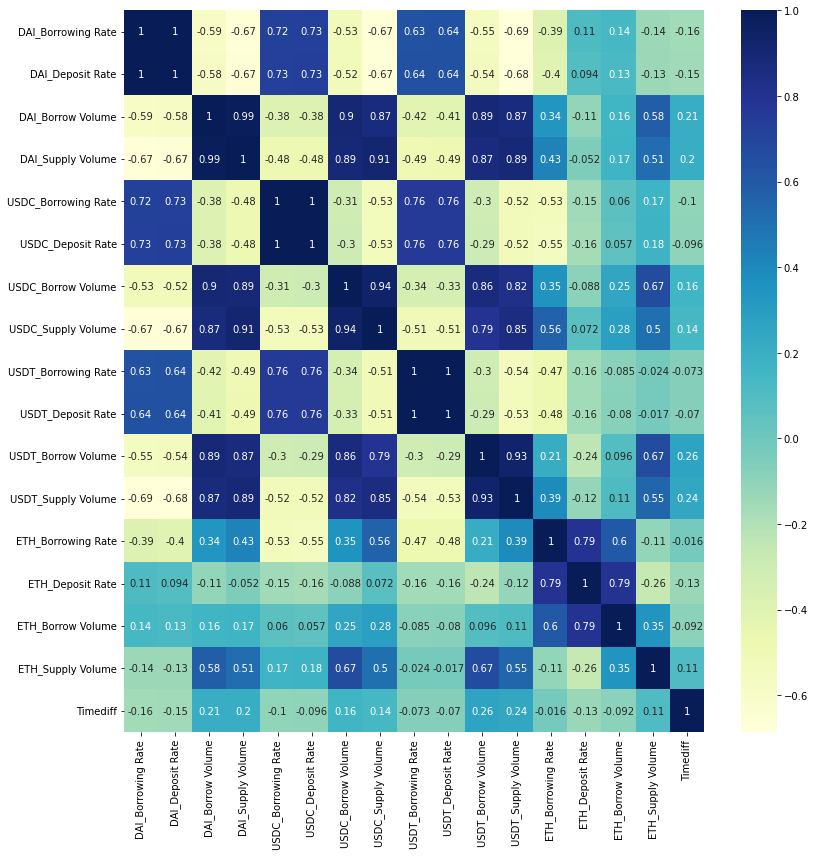

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(df1.drop('Timestamp', axis=1).corr(), annot=True, cmap="YlGnBu")
plt.tight_layout()

Some interesting observation, dai borrow rate is highly coorelated with usdc/usdt borrow rate but not eth, similarly for usdc and usdt

# Problem scoping
**Scope 1**
Can we predict a token's borrow rate at timepoint `t+n_windowns` in future given DAI, USDC, USDT, ETH  - borrow rate, deposit rate, borrow volume and supply volume at `t-0`? 

**Scope 2**
Can we predict a token's borrow rate at timepoint `t+n_windowns` in future given DAI, USDC, USDT, ETH  - borrow rate, deposit rate, borrow volume and supply volume at `n_timepoints` example at t-3, t-2, t-1, t-0? 

In [17]:
# df1['DAI_Target'] = df1['DAI_Borrowing Rate'].shift(-3) cannot use this??

In [18]:
target_token = 'DAI'
target_column = f'{target_token}_Borrowing Rate'
target_window = 3
def get_target(row):

    try:
        target = df1[df1['Timestamp'] == row['Timestamp'] + 1800.0*target_window][target_column].values[0]
    except:
        target = np.NaN
    
    return target

In [19]:
df1[f'{target_token}_Target'] =  df1.apply(lambda x: get_target(x), axis=1)

In [20]:
df1 = df1.dropna()
df1 = df1.drop(['Timestamp', 'Date', 'Timediff'], axis=1)

In [21]:
#train_test_split
df1['Train'] = None
train_index = int(len(df1)*0.8)
df1.loc[:train_index, 'Train'] = True
df1.loc[train_index:, 'Train'] = False

In [22]:
df1

,DAI_Borrowing Rate,DAI_Deposit Rate,DAI_Borrow Volume,DAI_Supply Volume,USDC_Borrowing Rate,USDC_Deposit Rate,USDC_Borrow Volume,USDC_Supply Volume,USDT_Borrowing Rate,USDT_Deposit Rate,USDT_Borrow Volume,USDT_Supply Volume,ETH_Borrowing Rate,ETH_Deposit Rate,ETH_Borrow Volume,ETH_Supply Volume,DAI_Target,Train
0,0.073195,0.050982,1.069964e+09,6.196481e+10,0.087046,0.066993,7.285430e+08,4.063042e+10,0.099588,0.077548,6.430536e+07,3.696225e+09,0.022952,0.000489,30553.654354,5.663257e+07,0.073436,True
1,0.073101,0.050912,1.069961e+09,6.197050e+10,0.087053,0.066998,7.285469e+08,4.063019e+10,0.094890,0.073569,6.407877e+07,3.700299e+09,0.022952,0.000489,30553.703955,5.663353e+07,0.067829,True
2,0.073061,0.050882,1.069972e+09,6.197354e+10,0.087058,0.067003,7.285528e+08,4.063019e+10,0.085767,0.065933,6.399418e+07,3.729213e+09,0.022951,0.000489,30553.830472,5.664534e+07,0.066704,True
3,0.073436,0.051161,1.070496e+09,6.197966e+10,0.086921,0.066889,7.285713e+08,4.063660e+10,0.072946,0.055500,6.317162e+07,3.730028e+09,0.022952,0.000489,30553.786270,5.663860e+07,0.066708,True
4,0.067829,0.047015,1.070566e+09,6.234580e+10,0.086312,0.066383,7.285755e+08,4.066162e+10,0.057764,0.043239,6.256095e+07,3.752927e+09,0.022952,0.000489,30553.841412,5.663440e+07,0.066790,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13756,0.046650,0.031471,3.669882e+09,2.109054e+11,0.040323,0.025672,2.588018e+09,1.666458e+11,0.039179,0.024246,6.062863e+08,4.162129e+10,0.027231,0.000765,53139.698365,7.448813e+07,0.046637,False
13757,0.046646,0.031465,3.669895e+09,2.109253e+11,0.040317,0.025664,2.587664e+09,1.666482e+11,0.039127,0.024181,6.054853e+08,4.162108e+10,0.027231,0.000765,53139.770109,7.448817e+07,0.046636,False
13758,0.046644,0.031464,3.669904e+09,2.109312e+11,0.040301,0.025643,2.587190e+09,1.666826e+11,0.039243,0.024324,6.072485e+08,4.162099e+10,0.027232,0.000765,53143.491452,7.447149e+07,0.046639,False
13760,0.046636,0.031453,3.669920e+09,2.109667e+11,0.040307,0.025651,2.587711e+09,1.666908e+11,0.039234,0.024314,6.072520e+08,4.162990e+10,0.027234,0.000765,53161.994342,7.447244e+07,0.046638,False


# Scope 1 

## sklearn's linear regression

In [23]:
#Build a simple Linear regression and split train test - from VintageGold

from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [24]:
train_X = df1[df1['Train']==True].drop(['Train', f'{target_token}_Target'], axis=1).values
train_y = df1[df1['Train']==True][f'{target_token}_Target'].values
test_X = df1[df1['Train']!=True].drop(['Train', f'{target_token}_Target'], axis=1).values
test_y = df1[df1['Train']!=True][f'{target_token}_Target'].values

In [25]:
scaler = MinMaxScaler()

In [26]:
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
#not sure if y should be scaled

In [27]:
model = LR()
model.fit(train_X,train_y)
preds = model.predict(test_X)

In [28]:
print(type(model).__name__,":",r2_score(test_y, preds))

LinearRegression : 0.8538437276980357


In [29]:
pd.DataFrame([test_y, preds]).T

,0,1
0,0.041877,0.041774
1,0.041875,0.041778
2,0.041870,0.041780
3,0.041870,0.041776
4,0.041898,0.041765
...,...,...
2948,0.046637,0.046887
2949,0.046636,0.046882
2950,0.046639,0.046885
2951,0.046638,0.046875


# Simple Tabular Model Using fastai

In [30]:
df1.columns

Index(['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume',
       'DAI_Supply Volume', 'USDC_Borrowing Rate', 'USDC_Deposit Rate',
       'USDC_Borrow Volume', 'USDC_Supply Volume', 'USDT_Borrowing Rate',
       'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
       'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume',
       'ETH_Supply Volume', 'DAI_Target', 'Train'],
      dtype='object')

In [31]:
df1 = df1.reset_index(drop=True)

In [32]:
splits = (list(df1[df1['Train']==True].index), list(df1[df1['Train']==False].index))

In [33]:
df1.columns

Index(['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume',
       'DAI_Supply Volume', 'USDC_Borrowing Rate', 'USDC_Deposit Rate',
       'USDC_Borrow Volume', 'USDC_Supply Volume', 'USDT_Borrowing Rate',
       'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
       'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume',
       'ETH_Supply Volume', 'DAI_Target', 'Train'],
      dtype='object')

In [34]:
cont_names = ['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume', 'DAI_Supply Volume', 
              'USDC_Borrowing Rate', 'USDC_Deposit Rate', 'USDC_Borrow Volume', 'USDC_Supply Volume', 
              'USDT_Borrowing Rate', 'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
              'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume', 'ETH_Supply Volume']

procs = [Categorify, FillMissing, Normalize]
y_names = f'{target_token}_Target'
y_block = RegressionBlock()

to = TabularPandas(df1, procs=procs, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)
dls = to.dataloaders(bs=128)

In [35]:
len(to.train), len(to.valid) 

(8965, 2953)

In [36]:
sm = SaveModelCallback(fname='scope1_fastaitabmodel')

In [37]:
learn = tabular_learner(dls, 
                        [200,100], 
                        metrics=rmse,
                        cbs=sm)

In [38]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=16, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [39]:
learn.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.00019054606673307717)

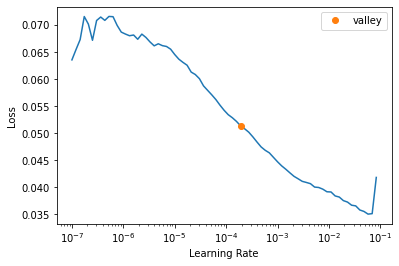

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(100, 0.03)

epoch,train_loss,valid_loss,_rmse,time
0,0.017845,0.003559,0.059654,00:00
1,0.004419,0.003394,0.058258,00:00
2,0.001696,0.003510,0.059248,00:00
3,0.000910,0.001355,0.036812,00:00
4,0.000790,0.001006,0.031713,00:00
5,0.000600,0.001000,0.031619,00:00
6,0.000761,0.001274,0.035694,00:00
7,0.000909,0.000659,0.025663,00:00
8,0.000454,0.000284,0.016846,00:00
9,0.000403,0.000244,0.015617,00:00


Better model found at epoch 0 with valid_loss value: 0.003558550728484988.
Better model found at epoch 1 with valid_loss value: 0.0033940423745661974.
Better model found at epoch 3 with valid_loss value: 0.0013551206793636084.
Better model found at epoch 4 with valid_loss value: 0.0010057393228635192.
Better model found at epoch 5 with valid_loss value: 0.0009997361339628696.
Better model found at epoch 7 with valid_loss value: 0.0006586056551896036.
Better model found at epoch 8 with valid_loss value: 0.0002837809734046459.
Better model found at epoch 9 with valid_loss value: 0.00024390558246523142.
Better model found at epoch 12 with valid_loss value: 0.00023688023793511093.
Better model found at epoch 13 with valid_loss value: 6.453095556935295e-05.
Better model found at epoch 15 with valid_loss value: 5.412257814896293e-05.
Better model found at epoch 19 with valid_loss value: 8.72501823323546e-06.
Better model found at epoch 20 with valid_loss value: 7.5844486673304345e-06.
Better

In [42]:
preds, targs = learn.get_preds(dl=dls.valid)

In [43]:
print("fastai TabModel",":",r2_score(preds.numpy(), targs.numpy()))

fastai TabModel : 0.9050618317267276


## TabNet/SAINT

# Scope - 2

For scope 2, we will assume each timepoint is 30mins apart 

## Simple Tabular Model Using fastai

In [62]:
target_token = 'DAI'
target_column = f'{target_token}_Borrowing Rate'
target_window = 3
n_sequence = 3

In [63]:
feature_cols = ['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume', 'DAI_Supply Volume', 
                'USDC_Borrowing Rate', 'USDC_Deposit Rate', 'USDC_Borrow Volume', 'USDC_Supply Volume', 
                'USDT_Borrowing Rate', 'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
                'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume', 'ETH_Supply Volume']

feature_cols

['DAI_Borrowing Rate',
 'DAI_Deposit Rate',
 'DAI_Borrow Volume',
 'DAI_Supply Volume',
 'USDC_Borrowing Rate',
 'USDC_Deposit Rate',
 'USDC_Borrow Volume',
 'USDC_Supply Volume',
 'USDT_Borrowing Rate',
 'USDT_Deposit Rate',
 'USDT_Borrow Volume',
 'USDT_Supply Volume',
 'ETH_Borrowing Rate',
 'ETH_Deposit Rate',
 'ETH_Borrow Volume',
 'ETH_Supply Volume']

In [64]:
cols_names = []
for j in range(n_sequence):
    for col in feature_cols:
        cols_names.append(f'{col}_t-{n_sequence -j-1}')
cols_names.append(f'{target_token}_Target')

In [47]:
pairs = []
for i, row in tqdm(df1.iterrows()):
    if i < len(df1)-target_window-5:
        features = df1.loc[i:i+n_sequence-1, feature_cols].values
        features = [item for sublist in features for item in sublist]
        targ = df1.loc[i+n_sequence-1+target_window, target_column]
        features.append(targ)
        pairs.append(features)

11918it [00:12, 974.77it/s] 


In [48]:
df2 = pd.DataFrame(pairs,columns=cols_names)

In [65]:
#train_test_split
df2['Train'] = None
train_index = int(len(df2)*0.8)
df2.loc[:train_index, 'Train'] = True
df2.loc[train_index:, 'Train'] = False

In [66]:
splits = (list(df2[df2['Train']==True].index), list(df2[df2['Train']==False].index))

In [67]:
cont_names = ['DAI_Borrowing Rate_t-2', 'DAI_Deposit Rate_t-2', 'DAI_Borrow Volume_t-2', 'DAI_Supply Volume_t-2',
              'USDC_Borrowing Rate_t-2', 'USDC_Deposit Rate_t-2', 'USDC_Borrow Volume_t-2', 'USDC_Supply Volume_t-2',
              'USDT_Borrowing Rate_t-2', 'USDT_Deposit Rate_t-2', 'USDT_Borrow Volume_t-2', 'USDT_Supply Volume_t-2',
              'ETH_Borrowing Rate_t-2', 'ETH_Deposit Rate_t-2', 'ETH_Borrow Volume_t-2', 'ETH_Supply Volume_t-2',
              'DAI_Borrowing Rate_t-1', 'DAI_Deposit Rate_t-1', 'DAI_Borrow Volume_t-1', 'DAI_Supply Volume_t-1',
              'USDC_Borrowing Rate_t-1', 'USDC_Deposit Rate_t-1', 'USDC_Borrow Volume_t-1', 'USDC_Supply Volume_t-1',
              'USDT_Borrowing Rate_t-1', 'USDT_Deposit Rate_t-1', 'USDT_Borrow Volume_t-1', 'USDT_Supply Volume_t-1',
              'ETH_Borrowing Rate_t-1', 'ETH_Deposit Rate_t-1', 'ETH_Borrow Volume_t-1', 'ETH_Supply Volume_t-1',
              'DAI_Borrowing Rate_t-0', 'DAI_Deposit Rate_t-0', 'DAI_Borrow Volume_t-0', 'DAI_Supply Volume_t-0',
              'USDC_Borrowing Rate_t-0', 'USDC_Deposit Rate_t-0', 'USDC_Borrow Volume_t-0', 'USDC_Supply Volume_t-0',
              'USDT_Borrowing Rate_t-0', 'USDT_Deposit Rate_t-0', 'USDT_Borrow Volume_t-0', 'USDT_Supply Volume_t-0', 
              'ETH_Borrowing Rate_t-0', 'ETH_Deposit Rate_t-0', 'ETH_Borrow Volume_t-0', 'ETH_Supply Volume_t-0']

In [68]:
procs = [Categorify, FillMissing, Normalize]
y_names = f'{target_token}_Target'
y_block = RegressionBlock()

to = TabularPandas(df2, procs=procs, cont_names=cont_names, y_names=y_names, y_block=y_block, splits=splits)
dls = to.dataloaders(bs=128)

In [69]:
len(to.train), len(to.valid) 

(9528, 2382)

In [70]:
sm = SaveModelCallback(fname='scope2_fastaitabmodel')

In [71]:
learn = tabular_learner(dls, 
                        [200,100], 
                        metrics=rmse,
                        cbs=sm)

In [72]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=48, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [73]:
learn.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0006918309954926372)

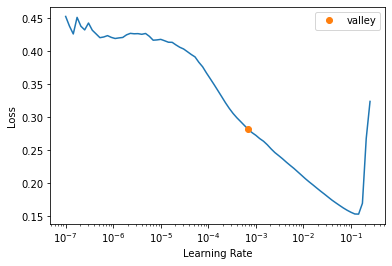

In [74]:
learn.lr_find()

In [59]:
learn.fit_one_cycle(100, 0.03)

epoch,train_loss,valid_loss,_rmse,time
0,0.023014,0.008198,0.090545,00:00
1,0.005105,0.003949,0.062843,00:00
2,0.001571,0.002540,0.050398,00:00
3,0.000753,0.001865,0.043185,00:00
4,0.000649,0.001125,0.033539,00:00
5,0.000938,0.000749,0.027365,00:00
6,0.000765,0.001592,0.039901,00:00
7,0.000476,0.001762,0.041974,00:00
8,0.000821,0.000569,0.023861,00:00
9,0.000589,0.000467,0.021618,00:00


Better model found at epoch 0 with valid_loss value: 0.008198380470275879.
Better model found at epoch 1 with valid_loss value: 0.0039492445066571236.
Better model found at epoch 2 with valid_loss value: 0.0025399483274668455.
Better model found at epoch 3 with valid_loss value: 0.0018649715930223465.
Better model found at epoch 4 with valid_loss value: 0.0011248566443100572.
Better model found at epoch 5 with valid_loss value: 0.0007488356786780059.
Better model found at epoch 8 with valid_loss value: 0.0005693563143722713.
Better model found at epoch 9 with valid_loss value: 0.00046735111391171813.
Better model found at epoch 10 with valid_loss value: 0.00022449949756264687.
Better model found at epoch 11 with valid_loss value: 0.00016955562750808895.
Better model found at epoch 12 with valid_loss value: 5.7857261708704755e-05.
Better model found at epoch 18 with valid_loss value: 2.9198930860729888e-05.
Better model found at epoch 23 with valid_loss value: 2.268754724354949e-05.
Bet

In [60]:
preds, targs = learn.get_preds(dl=dls.valid)

In [61]:
print("fastai TabModel using n_timepoints",":",r2_score(preds.numpy(), targs.numpy()))

fastai TabModel using n_timepoints : 0.868915958923015


## LSTM

In [ ]:
#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [76]:
from torch.utils.data import Dataset

In [110]:
class LSTMDataset(Dataset):
    def __init__(self, df, 
                 n_timepoints=n_sequence, 
                 targetcol=target_token, 
                 numfeatpertimepoint=len(feature_cols)):
        self.df = df.items.reset_index(drop=True)
        self.n_sequence = n_sequence
        self.numfeatures = numfeatpertimepoint
        self.targetcol = f'{target_token}_Target'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index,:]
        target = tensor(row[self.targetcol])
        features = [tensor(list(row[i*self.numfeatures:(i*self.numfeatures+self.numfeatures)].values)) for i in range(self.n_sequence)]
        features = torch.stack(features)
        return (features, target)

In [111]:
train_dset = LSTMDataset(to.train)
valid_dset = LSTMDataset(to.valid)

In [112]:
dls = DataLoaders.from_dsets(train_dset, valid_dset, bs=128)

In [113]:
dls.one_batch()

(tensor([[[-0.9310, -0.9224,  1.1617,  ...,  0.7311,  0.8004,  0.2496],
          [-0.9302, -0.9213,  1.1721,  ...,  0.7312,  0.8003,  0.2493],
          [-0.9300, -0.9210,  1.1732,  ...,  0.7295,  0.8012,  0.2520]],
 
         [[ 2.3163,  2.3261, -1.5246,  ...,  1.0872,  0.1673, -1.0529],
          [ 2.3017,  2.3107, -1.5247,  ...,  1.0991,  0.1670, -1.0605],
          [ 2.2292,  2.2342, -1.5260,  ...,  1.0867,  0.1668, -1.0530]],
 
         [[-1.0576, -1.1116, -0.0396,  ...,  0.7791,  0.1289, -0.5385],
          [-1.0575, -1.1115, -0.0399,  ...,  0.7790,  0.1286, -0.5387],
          [-1.0573, -1.1113, -0.0402,  ...,  0.7788,  0.1283, -0.5388]],
 
         ...,
 
         [[-0.9847, -1.0049,  1.2630,  ...,  0.3864,  0.4924,  0.2603],
          [-0.9839, -1.0039,  1.2625,  ...,  0.3829,  0.4922,  0.2641],
          [-0.9838, -1.0037,  1.2622,  ...,  0.3804,  0.4920,  0.2665]],
 
         [[ 0.1321,  0.1139,  0.6783,  ..., -0.2942,  0.2285,  0.8579],
          [ 0.1321,  0.1140,  0.6781

In [114]:
input_size = len(feature_cols)
sequence_length = n_sequence
num_layers = 2
hidden_size = 128

In [115]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, num_classes=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [116]:
model = LSTMModel(input_size, hidden_size)

In [117]:
sm = SaveModelCallback(fname='scope2_lstm')
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=sm)

In [118]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.003493,0.000132,0.011481,00:09
1,0.000755,0.000077,0.008779,00:09
2,0.000186,0.000012,0.003518,00:09
3,0.000062,0.000010,0.003117,00:09
4,0.000038,0.000012,0.003402,00:09
5,0.000028,0.000007,0.002726,00:09
6,0.000029,0.000005,0.002275,00:09
7,0.000031,0.000008,0.002860,00:09
8,0.000030,0.000005,0.002297,00:09
9,0.000025,0.000007,0.002607,00:09


Better model found at epoch 0 with valid_loss value: 0.00013181843678466976.
Better model found at epoch 1 with valid_loss value: 7.707839540671557e-05.
Better model found at epoch 2 with valid_loss value: 1.2375814549159259e-05.
Better model found at epoch 3 with valid_loss value: 9.716943168314174e-06.
Better model found at epoch 5 with valid_loss value: 7.4312533797638025e-06.
Better model found at epoch 6 with valid_loss value: 5.1739079935941845e-06.
Better model found at epoch 15 with valid_loss value: 4.975192950951168e-06.
Better model found at epoch 16 with valid_loss value: 4.648171852750238e-06.


In [119]:
preds, targs = learn.get_preds(dl=dls.valid)

In [120]:
print("Scope 2 LSTM Model",":",r2_score(preds.numpy(), targs.numpy()))

Scope 2 LSTM Model : 0.8303779789508886


## TabNet/SAINT